In [0]:
#!pip install keras==2.3.1  
#!pip uninstall opencv-python -y
#!pip install opencv-contrib-python==3.4.2.17 --force-reinstall
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix,plot_confusion_matrix
import matplotlib.pyplot as plt
from numpy import asarray
from pathlib import Path
import cv2
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.svm import LinearSVC,SVC
from sklearn.neighbors import KNeighborsClassifier,NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from numpy import load
from numpy import savez_compressed
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import svm
import seaborn as sn
from google.colab import drive
import random

In [85]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
directory = '/content/drive/My Drive/CMPE255/src/'

In [0]:
# Reading the dataset
fer_data=pd.read_csv(directory+'Data/fer2013.csv',delimiter=',')

In [0]:
# Getting images and labels
def load_data():
    images = []
    labels = []
    for index,row in fer_data.iterrows():
        pixels=np.asarray(list(row['pixels'].split(' ')),dtype=np.uint8)
        img=pixels.reshape((48,48))
        labels.append(row['emotion'])
        images.append(img)
    return (images,labels)

---
## **Load the data from the CSV**
---






In [89]:
%time images,labels = load_data()

CPU times: user 21 s, sys: 658 ms, total: 21.6 s
Wall time: 21.6 s


In [0]:
# Function to plot images
def plot_images(data,label):
  emotion = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happy', 4 :'Sad', 5 : 'Surprise', 6 : 'Neutral'}
  f, axarr = plt.subplots(2,2,constrained_layout=True)
  axarr[0,0].imshow(data[0])
  axarr[0,0].set_title(emotion[label[0]])
  axarr[0,1].imshow(data[1])
  axarr[0,1].set_title(emotion[label[1]])
  axarr[1,0].imshow(data[2])
  axarr[1,0].set_title(emotion[label[2]])
  axarr[1,1].imshow(data[3])
  axarr[1,1].set_title(emotion[label[3]])

## Visualise four randomly selected images from the dataset

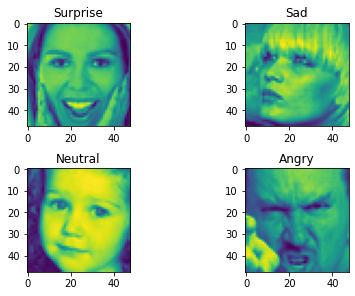

In [91]:
#randomly select 4 images
idx = np.random.choice(len(images),4,False)
plot_images([images[i] for i in idx] ,[labels[i] for i in idx])

In [0]:
num_clusters = 100
num_classes = 7
img_width = 48
img_height = 48

In [0]:
# Extracting SIFT Descriptors
def extractSIFTDescriptors(image):
  sift = cv2.xfeatures2d.SIFT_create()
  kp, des = sift.detectAndCompute(image,None)
  return (kp,des)

# Extracting features
def extractFeatures(images):
  #Stores all the descriptors found
  SIFTdesc = [] 
  #Each element corresponds to the descriptors found in an image
  img_desc = []
  for image in images:
    kp,des = extractSIFTDescriptors(image)
    if des is not None:
      SIFTdesc.extend(des)
      img_desc.append(des)
    else:
      img_desc.append([])
  return (SIFTdesc,img_desc)  

# Creating Histograms
def constructHistogram(kmeans,image_descs,num_words):
  histograms = []
  for image_desc in image_descs:
      visual_words = []
      if len(image_desc):
        visual_words = kmeans.predict(image_desc)
      histograms.append(np.bincount(visual_words ,minlength=num_words))
  return np.array(histograms)

In [94]:
%time SIFTdesc,image_desc = extractFeatures(images)

CPU times: user 2min 22s, sys: 10 s, total: 2min 32s
Wall time: 1min 17s


In [95]:
%time kmeans =   MiniBatchKMeans(init ='k-means++',init_size=num_clusters+10, batch_size = 64, verbose = 0).fit(SIFTdesc) 

CPU times: user 13.9 s, sys: 167 ms, total: 14 s
Wall time: 13.9 s


In [96]:
%time X = constructHistogram(kmeans,image_desc,num_clusters)

CPU times: user 18.4 s, sys: 17.2 ms, total: 18.4 s
Wall time: 18.4 s


In [0]:
# Splitting into test and train datasets
X_train, X_test, y_train, y_test = train_test_split(X,labels,stratify=labels, test_size=0.2, random_state=42)

In [98]:
print("Train Set : " ,len(y_train),"images")
print("Test Set : " ,len(y_test),"images")

Train Set :  28709 images
Test Set :  7178 images


In [0]:
# Creating algorithm instance
algo = DecisionTreeClassifier(max_depth=1000)

## Train the model on train data

In [120]:
# Training the model
%time algo.fit(X_train,y_train)

CPU times: user 183 ms, sys: 2.04 ms, total: 185 ms
Wall time: 189 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1000, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

## Evaluate the model

In [121]:
# Evaluating the model
algo.score(X_test,y_test)

0.2509055447199777

## Plot the confusion matrix

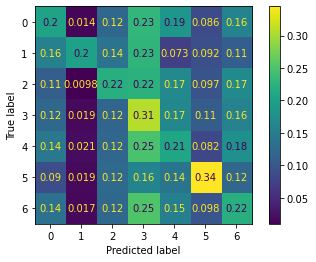

In [122]:
# Plotting the confusion matrix
plot_confusion_matrix(algo,X_test,y_test,normalize='true')